# Run an inversion on the data you calculated

In [2]:
# -*- coding: utf-8 -*-
! pip install simpeg 
"""
Least-Squares 1D Inversion of Sounding Data
===========================================

Here we use the module *SimPEG.electromangetics.static.resistivity* to invert
DC resistivity sounding data and recover a 1D electrical resistivity model.
In this tutorial, we focus on the following:

    - How to define sources and receivers from a survey file
    - How to define the survey
    - 1D inversion of DC resistivity data

For this tutorial, we will invert sounding data collected over a layered Earth using
a Wenner array. The end product is layered Earth model which explains the data.


"""

#########################################################################
# Import modules
# --------------
#

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tarfile

from discretize import TensorMesh

from SimPEG import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
    utils,
)
from SimPEG.electromagnetics.static import resistivity as dc
from SimPEG.electromagnetics.static.utils.static_utils import plot_layer


Defaulting to user installation because normal site-packages is not writeable


# Set the files to invert

In [ ]:
#############################################
# Define File Names
# -----------------
#
# Here we provide the file paths to assets we need to run the inversion. The
# Path to the true model is also provided for comparison with the inversion
# results. These files are stored as a tar-file on our google cloud bucket:
# "https://storage.googleapis.com/simpeg/doc-assets/dcip1d.tar.gz"
#

# storage bucket where we have the data
#data_source = "https://storage.googleapis.com/simpeg/doc-assets/dcip1d.tar.gz"

# download the data
#downloaded_data = utils.download(data_source, overwrite=True)

# unzip the tarfile
#tar = tarfile.open(downloaded_data, "r")
#tar.extractall()
#tar.close()

# path to the directory containing our data
dir_path = "./equivalence/" 

# files to work with, change model2 to model1 for first example...
data_filename = dir_path + "model2.dobs"
model_filename = dir_path + "true_model2.txt"
mesh_filename = dir_path + "layers2.txt"

# Perform inversion

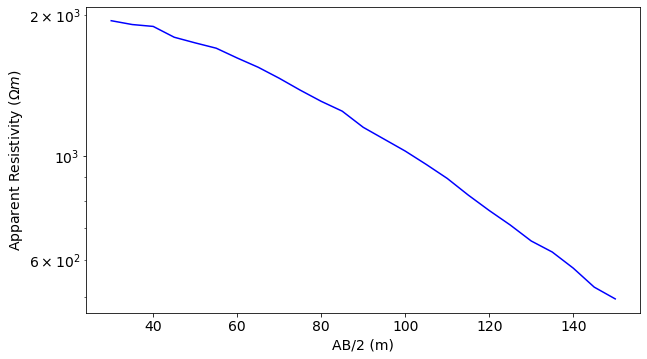


  TensorMesh: 31 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     31          0.00        242.18      5.00     11.19    1.03



        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.09e+02  2.02e+04  0.00e+00  2.02e+04    2.44e+03      0              
   1  1.09e+02  4.83e+03  8.52e+00  5.76e+03    3.21e+03      1              
   2  1.09e+02  6.15e+02  1.74e+01  2.51e+03    2.45e+03      0              
   3  2.18e+01  1.25e+02  1.32e+01  4.13e+02 

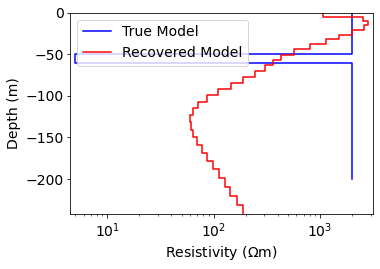

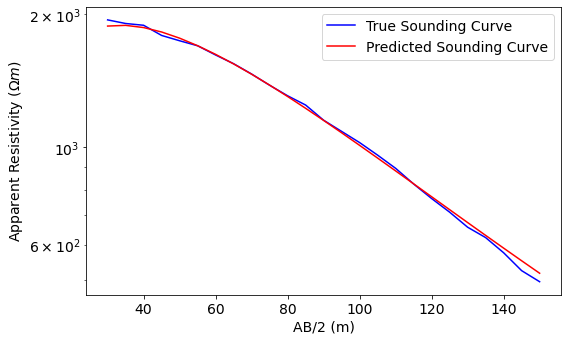

In [1]:
#############################################
# Load Data, Define Survey and Plot
# ---------------------------------
#
# Here we load the observed data, define the DC survey geometry and plot the
# data values.
#

# Load data
dobs = np.loadtxt(str(data_filename))

# Extract source and receiver electrode locations and the observed data
A_electrodes = dobs[:, 0:3]
B_electrodes = dobs[:, 3:6]
M_electrodes = dobs[:, 6:9]
N_electrodes = dobs[:, 9:12]
dobs = dobs[:, -1]

# Define survey
unique_tx, k = np.unique(np.c_[A_electrodes, B_electrodes], axis=0, return_index=True)
n_sources = len(k)
k = np.sort(k)
k = np.r_[k, len(k) + 1]

source_list = []
for ii in range(0, n_sources):

    # MN electrode locations for receivers. Each is an (N, 3) numpy array
    M_locations = M_electrodes[k[ii] : k[ii + 1], :]
    N_locations = N_electrodes[k[ii] : k[ii + 1], :]
    receiver_list = [dc.receivers.Dipole(M_locations, N_locations)]

    # AB electrode locations for source. Each is a (1, 3) numpy array
    A_location = A_electrodes[k[ii], :]
    B_location = B_electrodes[k[ii], :]
    source_list.append(dc.sources.Dipole(receiver_list, A_location, B_location))

# Define survey
survey = dc.Survey(source_list)

# Plot apparent resistivities on sounding curve as a function of Wenner separation
# parameter.
electrode_separations = 0.5 * np.sqrt(
    np.sum((survey.locations_a - survey.locations_b) ** 2, axis=1)
)

fig = plt.figure(figsize=(11, 5))
mpl.rcParams.update({"font.size": 14})
ax1 = fig.add_axes([0.15, 0.1, 0.7, 0.85])
ax1.semilogy(electrode_separations, dobs, "b")
ax1.set_xlabel("AB/2 (m)")
ax1.set_ylabel("Apparent Resistivity ($\Omega m$)")
plt.show()

###############################################
# Assign Uncertainties
# --------------------
#
# Inversion with SimPEG requires that we define standard deviation on our data.
# This represents our estimate of the noise in our data. For DC sounding data,
# a relative error is applied to each datum. For this tutorial, the relative
# error on each datum will be 2%.

std = 0.02 * np.abs(dobs)


###############################################
# Define Data
# --------------------
#
# Here is where we define the data that are inverted. The data are defined by
# the survey, the observation values and the standard deviation.
#

data_object = data.Data(survey, dobs=dobs, standard_deviation=std)


###############################################
# Defining a 1D Layered Earth (1D Tensor Mesh)
# --------------------------------------------
#
# Here, we define the layer thicknesses for our 1D simulation. To do this, we use
# the TensorMesh class.
#

# Define layer thicknesses
layer_thicknesses = 5 * np.logspace(0, .35, 30)

# Define a mesh for plotting and regularization.
mesh = TensorMesh([(np.r_[layer_thicknesses, layer_thicknesses[-1]])], "0")

print(mesh)

###############################################################
# Define a Starting and Reference Model
# -------------------------------------
#
# Here, we create starting and/or reference models for the inversion as
# well as the mapping from the model space to the active cells. Starting and
# reference models can be a constant background value or contain a-priori
# structures. Here, the starting model is log(1000) Ohm meters.
#
# Define log-resistivity values for each layer since our model is the
# log-resistivity. Don't make the values 0!
# Otherwise the gradient for the 1st iteration is zero and the inversion will
# not converge.

# Define model. A resistivity (Ohm meters) or conductivity (S/m) for each layer.
starting_model = np.log(2e2 * np.ones((len(layer_thicknesses) + 1)))

# Define mapping from model to active cells.
model_map = maps.IdentityMap(nP=len(starting_model)) * maps.ExpMap()

#######################################################################
# Define the Physics
# ------------------
#
# Here we define the physics of the problem using the Simulation1DLayers class.
#

simulation = dc.simulation_1d.Simulation1DLayers(
    survey=survey,
    rhoMap=model_map,
    thicknesses=layer_thicknesses,
    data_type="apparent_resistivity",
)


#######################################################################
# Define Inverse Problem
# ----------------------
#
# The inverse problem is defined by 3 things:
#
#     1) Data Misfit: a measure of how well our recovered model explains the field data
#     2) Regularization: constraints placed on the recovered model and a priori information
#     3) Optimization: the numerical approach used to solve the inverse problem
#
#

# Define the data misfit. Here the data misfit is the L2 norm of the weighted
# residual between the observed data and the data predicted for a given model.
# Within the data misfit, the residual between predicted and observed data are
# normalized by the data's standard deviation.
dmis = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)

# Define the regularization (model objective function)
reg = regularization.Simple(mesh, alpha_s=1.0, alpha_x=1.0, mref=starting_model)

# Define how the optimization problem is solved. Here we will use an inexact
# Gauss-Newton approach that employs the conjugate gradient solver.
opt = optimization.InexactGaussNewton(maxIter=30, maxIterCG=20)

# Define the inverse problem
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

#######################################################################
# Define Inversion Directives
# ---------------------------
#
# Here we define any directives that are carried out during the inversion. This
# includes the cooling schedule for the trade-off parameter (beta), stopping
# criteria for the inversion and saving inversion results at each iteration.
#

# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e0)

# Set the rate of reduction in trade-off parameter (beta) each time the
# the inverse problem is solved. And set the number of Gauss-Newton iterations
# for each trade-off paramter value.
beta_schedule = directives.BetaSchedule(coolingFactor=5.0, coolingRate=3.0)

# Apply and update sensitivity weighting as the model updates
update_sensitivity_weights = directives.UpdateSensitivityWeights()

# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SaveOutputEveryIteration(save_txt=False)

# Setting a stopping criteria for the inversion.
target_misfit = directives.TargetMisfit(chifact=1)

# The directives are defined as a list.
directives_list = [
    update_sensitivity_weights,
    starting_beta,
    beta_schedule,
    save_iteration,
    target_misfit,
]

#####################################################################
# Running the Inversion
# ---------------------
#
# To define the inversion object, we need to define the inversion problem and
# the set of directives. We can then run the inversion.
#

# Here we combine the inverse problem and the set of directives
inv = inversion.BaseInversion(inv_prob, directives_list)

# Run the inversion
recovered_model = inv.run(starting_model)

############################################################
# Examining the Results
# ---------------------
#

# Load the true model and layer thicknesses
true_model = np.loadtxt(str(model_filename))
true_layers = np.loadtxt(str(mesh_filename))
true_layers = TensorMesh([true_layers], "N")

# Plot true model and recovered model
fig = plt.figure(figsize=(6, 4))
x_min = np.min([np.min(model_map * recovered_model), np.min(true_model)])
x_max = np.max([np.max(model_map * recovered_model), np.max(true_model)])

ax1 = fig.add_axes([0.2, 0.15, 0.7, 0.7])
plot_layer(true_model, true_layers, ax=ax1, depth_axis=False, color="b")
plot_layer(model_map * recovered_model, mesh, ax=ax1, depth_axis=False, color="r")
ax1.set_xlim(0.9 * x_min, 1.1 * x_max)
ax1.legend(["True Model", "Recovered Model"])

# Plot the true and apparent resistivities on a sounding curve
fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_axes([0.2, 0.1, 0.6, 0.8])
ax1.semilogy(electrode_separations, dobs, "b")
ax1.semilogy(electrode_separations, inv_prob.dpred, "r")
ax1.set_xlabel("AB/2 (m)")
ax1.set_ylabel("Apparent Resistivity ($\Omega m$)")
ax1.legend(["True Sounding Curve", "Predicted Sounding Curve"])
plt.show()